In [ ]:
!nvidia-smi

Sun Aug 10 12:53:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!gdown --folder "https://drive.google.com/drive/folders/1Rx4LCo-9AbAdPw5Zh7wpKhMKLabZ5oA8"

Retrieving folder contents
Processing file 13OgrD0-8cKG0X00MlA6JXr0G_JJmHYXg Crash-1500.txt
Processing file 1fmcwGhr8JT9YfLUrlcvuCZ3ychi2eyFP Crash-1500.zip
Processing file 11ErpWQmmV5au2JOQVxwYl3ebtuugdlan Normal.zip
Processing file 1uCF5giUjqYyaG3SST-cpJ549vbD1i4cu YouTube_download.py
Processing file 1xETn9viyjaEt4giYXZQI9Vs-oxEIJv4h ytb_list.txt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=13OgrD0-8cKG0X00MlA6JXr0G_JJmHYXg
To: /content/videos/Crash-1500.txt
100% 277k/277k [00:00<00:00, 4.88MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1fmcwGhr8JT9YfLUrlcvuCZ3ychi2eyFP
From (redirected): https://drive.google.com/uc?id=1fmcwGhr8JT9YfLUrlcvuCZ3ychi2eyFP&confirm=t&uuid=965bf5b2-86ca-4bcd-ada2-9e714f6ef37b
To: /content/videos/Crash-1500.zip
100% 793M/793M [00:14<00:00, 53.6MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=11ErpWQmmV5au2

In [ ]:

import zipfile
import os

zip_path = "/content/videos/Crash-1500.zip"
extract_to = "/content/d/accident"
os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Get video file names
    video_files = [f for f in zip_ref.namelist() if f.endswith(('.mp4', '.mov', '.avi'))]

    # Extract only the first 500
    for file in video_files[:500]:
        zip_ref.extract(file, path=extract_to)

print(f"✅ Extracted 500 videos to {extract_to}")

zip_path = "/content/videos/Normal.zip"
extract_to = "/content/d/normal"
os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Get video file names
    video_files = [f for f in zip_ref.namelist() if f.endswith(('.mp4', '.mov', '.avi'))]

    # Extract only the first 500
    for file in video_files[:500]:
        zip_ref.extract(file, path=extract_to)

print(f"✅ Extracted 500 videos to {extract_to}")

✅ Extracted 500 videos to /content/d/accident
✅ Extracted 500 videos to /content/d/normal


In [ ]:
import os
import cv2
import numpy as np
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:

SEGMENT_LENGTH = 32
FRAME_SIZE = (96, 96)
INPUT_SHAPE = (SEGMENT_LENGTH, FRAME_SIZE[0], FRAME_SIZE[1], 3)
BATCH_SIZE = 2
EPOCHS = 100
DATASET_PATH = "/content/d"
PROCESSED_PATH = "/content/processed2"
os.makedirs(PROCESSED_PATH, exist_ok=True)

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# ========================== #
#   AUGMENTATION FUNCTIONS   #
# ========================== #
def augment_video_segment(segment):
    # --- TEMPORAL AUGMENTATIONS ---
    # 1. Temporal shift
    if random.random() < 0.5:
        shift = random.randint(-4, 4)
        segment = np.roll(segment, shift, axis=0)

    # 2. Frame drop
    if random.random() < 0.3:
        drop_count = random.randint(1, 3)
        keep_indices = sorted(random.sample(range(len(segment)), len(segment) - drop_count))
        segment = segment[keep_indices]
        # Resize back to segment length
        while len(segment) < SEGMENT_LENGTH:
            segment = np.append(segment, [segment[-1]], axis=0)
        segment = segment[:SEGMENT_LENGTH]

    # 3. Reverse playback
    if random.random() < 0.1:
        segment = segment[::-1]

    # --- SPATIAL AUGMENTATIONS ---
    # Horizontal flip
    if random.random() < 0.5:
        segment = np.flip(segment, axis=2)

    # Brightness adjustment
    if random.random() < 0.5:
        factor = 1.0 + (0.2 * (random.random() - 0.5))
        segment = np.clip(segment * factor, 0, 1)

    # Random zoom
    if random.random() < 0.3:
        crop_size = random.randint(int(FRAME_SIZE[0] * 0.9), FRAME_SIZE[0])
        start_x = random.randint(0, FRAME_SIZE[0] - crop_size)
        start_y = random.randint(0, FRAME_SIZE[1] - crop_size)
        cropped = segment[:, start_y:start_y+crop_size, start_x:start_x+crop_size, :]
        segment = np.array([cv2.resize(frame, FRAME_SIZE) for frame in cropped])

    return segment

In [ ]:
class WeakVideoDataset:
    def __init__(self, dataset_path, processed_path, augment=False):
        self.classes = ['normal', 'accident']
        self.dataset_path = dataset_path
        self.processed_path = processed_path
        self.augment = augment

    def segment_video(self, path, segment_length=SEGMENT_LENGTH):
        cap = cv2.VideoCapture(path)
        frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, FRAME_SIZE)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) / 255.0
            frames.append(frame)
        cap.release()

        segments = []
        for i in range(0, len(frames) - segment_length + 1, segment_length):
            segments.append(np.array(frames[i:i + segment_length]))
        return np.array(segments)

    def preprocess_and_save(self, max_videos_per_class=None):
        for cls in self.classes:
            cls_dir = os.path.join(self.dataset_path, cls)
            save_cls_dir = os.path.join(self.processed_path, cls)
            os.makedirs(save_cls_dir, exist_ok=True)

            videos = [f for f in os.listdir(cls_dir) if f.endswith(('.mp4', '.mov', '.avi'))]
            if max_videos_per_class:
                videos = videos[:max_videos_per_class]  # process in small batches

            for vid in tqdm(videos, desc=f"Processing {cls} videos"):
                save_path = os.path.join(save_cls_dir, vid.rsplit('.', 1)[0] + '.npy')
                if os.path.exists(save_path):
                    continue
                segments = self.segment_video(os.path.join(cls_dir, vid))
                np.save(save_path, segments)

    def load_generator(self, batch_size=4, split='train', test_size=0.2):
        X_files, y_labels = [], []
        for idx, cls in enumerate(self.classes):
            cls_dir = os.path.join(self.processed_path, cls)
            files = [os.path.join(cls_dir, f) for f in os.listdir(cls_dir) if f.endswith('.npy')]
            X_files.extend(files)
            y_labels.extend([idx] * len(files))

        X_train, X_test, y_train, y_test = train_test_split(
            X_files, y_labels, stratify=y_labels, test_size=test_size, random_state=42
        )
        files_split, labels_split = (X_train, y_train) if split == 'train' else (X_test, y_test)

        while True:
            idxs = np.arange(len(files_split))
            np.random.shuffle(idxs)
            for i in range(0, len(idxs), batch_size):
                batch_files = [files_split[j] for j in idxs[i:i+batch_size]]
                batch_labels = [labels_split[j] for j in idxs[i:i+batch_size]]
                X_batch, y_batch = [], []

                for file_path, label in zip(batch_files, batch_labels):
                    segments = np.load(file_path)
                    for seg in segments:
                        if self.augment and split == 'train':
                            seg = augment_video_segment(seg)
                        X_batch.append(seg)
                        y_batch.append(label)

                yield np.array(X_batch), np.array(y_batch)

In [ ]:
def build_3d_cnn_model():
    inputs = layers.Input(shape=INPUT_SHAPE)
    x = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(inputs, output)

In [ ]:
# ========================== #
#     PREPROCESS & TRAIN     #
# ========================== #
loader = WeakVideoDataset(DATASET_PATH, PROCESSED_PATH, augment=True)

# Process dataset in chunks to save space (optional)
loader.preprocess_and_save()  # If too large: loader.preprocess_and_save(max_videos_per_class=200)

# Load generators
train_gen = loader.load_generator(batch_size=BATCH_SIZE, split='train')
test_gen = loader.load_generator(batch_size=BATCH_SIZE, split='test')

# Count steps based on total segments
def count_segments(processed_path, split_ratio=0.8):
    total_segments = 0
    for cls in ['normal', 'accident']:
        cls_dir = os.path.join(processed_path, cls)
        for f in os.listdir(cls_dir):
            if f.endswith('.npy'):
                total_segments += np.load(os.path.join(cls_dir, f)).shape[0]
    train_steps = int((total_segments * split_ratio) / BATCH_SIZE)
    val_steps = int((total_segments * (1 - split_ratio)) / BATCH_SIZE)
    return train_steps, val_steps

train_steps, test_steps = count_segments(PROCESSED_PATH)

Processing accident videos: 100%|██████████| 500/500 [01:00<00:00,  8.27it/s]


In [ ]:
# Build and compile model
model = build_3d_cnn_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train
print("[INFO] Training model on Colab...")
history = model.fit(
    train_gen,
    steps_per_epoch=train_steps,
    validation_data=test_gen,
    validation_steps=test_steps,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr]
)

# Save model
model.save("/content/weakly_supervised_3dcnn1.h5")
print("[INFO] Model saved.")

# ========================== #
#    CLEAN UP (Optional)     #
# ========================== #
# !rm -rf /content/processed

[INFO] Training model on Colab...
Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 40s 87ms/step - accuracy: 0.5857 - loss: 0.6674 - val_accuracy: 0.6313 - val_loss: 0.5921 - learning_rate: 0.0010
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 40s 100ms/step - accuracy: 0.6316 - loss: 0.6305 - val_accuracy: 0.6212 - val_loss: 0.6456 - learning_rate: 0.0010
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 39s 97ms/step - accuracy: 0.6647 - loss: 0.5738 - val_accuracy: 0.6616 - val_loss: 0.6033 - learning_rate: 0.0010
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 42s 106ms/step - accuracy: 0.6522 - loss: 0.5728 - val_accuracy: 0.6818 - val_loss: 0.5333 - learning_rate: 0.0010
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - accuracy: 0.7088 - loss: 0.5171 - val_accuracy: 0.6313 - val_loss: 0.6187 - learning_rate: 0.0010
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 24s 59ms/step - accuracy: 0.7528 - loss: 0.5113 - val_accuracy: 0.7323 - val_loss: 0.5245 - learning_rate: 0.0010
Epoch 7/100
400/400 ━━━━━━━━━━━━━━

[INFO] Model saved.


In [ ]:
model.evaluate(test_gen, steps=test_steps)


99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9094 - loss: 0.2655


[0.2863156497478485, 0.9040403962135315]

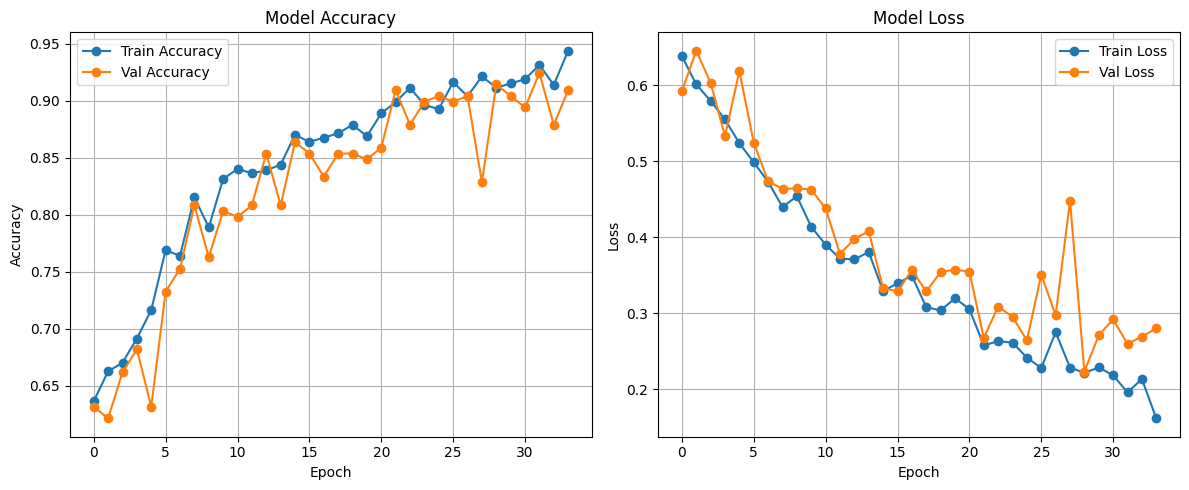

[INFO] Training plot saved at training_validation_curves1.png


In [ ]:
# ======== VISUALIZE TRAINING ======== #
import matplotlib.pyplot as plt

def plot_training_history(history, save_path="training_plot.png"):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    print(f"[INFO] Training plot saved at {save_path}")

# Call the function after training
plot_training_history(history, save_path="training_validation_curves1.png")

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc, precision_recall_curve
)
import seaborn as sns

# Collect predictions and true labels
y_true, y_pred_probs = [], []

for i in range(test_steps):
    X_batch, y_batch = next(test_gen)
    preds = model.predict(X_batch)
    y_true.extend(y_batch)
    y_pred_probs.extend(preds.flatten())
y_pred = [1 if p >= 0.5 else 0 for p in y_pred_probs]

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred_probs)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Accident"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.close()

fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc_val = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_val:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.savefig("roc_curve.png")
plt.close()

precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_pred_probs)

plt.figure()
plt.plot(recall_vals, precision_vals, label="PR Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.savefig("pr_curve.png")
plt.close()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

def smooth_predictions(preds, window):
    return np.convolve(preds, np.ones(window)/window, mode='same')
best_f1 = 0
best_threshold = 0.5
best_window = 1

thresholds = np.arange(0.1, 0.9, 0.05)
windows = [1, 3, 5, 7, 9, 11]

for w in windows:
    smoothed = smooth_predictions(np.array(y_pred_probs), w)
    for t in thresholds:
        preds = (smoothed >= t).astype(int)
        score = f1_score(y_true, preds)
        if score > best_f1:
            best_f1 = score
            best_threshold = t
            best_window = w

print(f"[BEST CONFIG] Threshold: {best_threshold}, Window: {best_window}, F1 Score: {best_f1:.4f}")


[BEST CONFIG] Threshold: 0.5000000000000001, Window: 1, F1 Score: 0.9100


In [ ]:
import cv2
import numpy as np
import tensorflow as tf

# ==== CONFIG ====
MODEL_PATH = "weakly_supervised_3dcnn1.h5"
VIDEO_PATH = "/content/FullSizeRender (2).MOV"  # Change to your video
OUTPUT_PATH = "output_labeledyy.mp4"
SEGMENT_LENGTH = 32
FRAME_SIZE = (96, 96)
THRESHOLD = 0.5
SMOOTHING_WINDOW = 1

# ==== LOAD MODEL ====
model = tf.keras.models.load_model(MODEL_PATH)
print("[INFO] Model loaded.")

# ==== HELPER: segment video into chunks ====
def segment_video_for_inference(video_path, segment_length=32):
    cap = cv2.VideoCapture(video_path)
    frames = []
    orig_frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        orig_frames.append(frame.copy())
        frame_resized = cv2.resize(frame, FRAME_SIZE)
        frame_resized = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB) / 255.0
        frames.append(frame_resized)
    cap.release()

    # Create 32-frame segments
    segments = []
    segment_indices = []  # store starting frame index of each segment
    for i in range(0, len(frames) - segment_length + 1, segment_length):
        segments.append(np.array(frames[i:i+segment_length]))
        segment_indices.append(i)
    return np.array(segments), segment_indices, orig_frames

# ==== SMOOTHING ====
def smooth_predictions(preds, window=3):
    return np.convolve(preds, np.ones(window)/window, mode='same')

# ==== LOAD VIDEO ====
segments, segment_indices, orig_frames = segment_video_for_inference(VIDEO_PATH, SEGMENT_LENGTH)
print(f"[INFO] Total segments: {len(segments)}")

# ==== PREDICT ====
preds = model.predict(segments).flatten()
preds_smooth = smooth_predictions(preds, SMOOTHING_WINDOW)
labels = (preds_smooth >= THRESHOLD).astype(int)

# ==== CREATE OUTPUT VIDEO ====
height, width = orig_frames[0].shape[:2]
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(OUTPUT_PATH, fourcc, 30, (width, height))

# Assign segment labels to frames
frame_labels = np.zeros(len(orig_frames), dtype=int)
for seg_idx, start_frame in enumerate(segment_indices):
    frame_labels[start_frame:start_frame+SEGMENT_LENGTH] = labels[seg_idx]

# Write frames with labels
for idx, frame in enumerate(orig_frames):
    label_val = frame_labels[idx]
    label_text = f"{label_val}"
    color = (0, 0, 255) if label_val == 1 else (0, 255, 0)  # Red for accident, green for normal

    cv2.putText(frame, f"Label: {label_text}", (30, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 1.2, color, 3)
    out.write(frame)

out.release()
print(f"[INFO] Labeled video saved to {OUTPUT_PATH}")

[INFO] Model loaded.
[INFO] Total segments: 22
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[INFO] Labeled video saved to output_labeledyy.mp4
